# Movie Recommendation System (Content-Based + Item-Based CF)

#  Import libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Datasets

In [26]:
movies = pd.read_csv(r"C:\Users\verma\Downloads\movies.csv")
ratings = pd.read_csv(r"C:\Users\verma\Downloads\ratings.csv")


In [27]:
print("Movies dataset:")
print(movies.head(), "\n")

print("Ratings dataset:")
print(ratings.head(), "\n")


Movies dataset:
   movieId                   title                             genres  year
0        1               Toy Story  Animation|Adventure|Comedy|Family  1995
1        2                 Jumanji           Adventure|Family|Fantasy  1995
2        3        Grumpier Old Men                     Romance|Comedy  1995
3        4       Waiting to Exhale                      Drama|Romance  1995
4        5  Father of the Bride II                      Comedy|Family  1995 

Ratings dataset:
   userId  movieId  rating  timestamp
0       1        5     2.9  870035191
1       1       10     4.2  857079802
2       1        7     4.8  865045955
3       1       15     3.2  842723872
4       1       14     4.3  836522907 



# 2. Content-Based Filtering (Genre Similarity)

In [28]:
# Extract all unique genres
all_genres = sorted({g for cell in movies["genres"] for g in cell.split("|")})
genre_to_idx = {g: i for i, g in enumerate(all_genres)}


In [29]:
# Multi-hot encode genres
def create_genre_matrix(movies_df):
    G = np.zeros((len(movies_df), len(all_genres)))
    for i, row in movies_df.iterrows():
        for g in row["genres"].split("|"):
            G[i, genre_to_idx[g]] = 1
    return G
    
G = create_genre_matrix(movies)

In [30]:
# Cosine similarity function
def cosine_similarity_matrix(X):
    norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-9
    Xn = X / norms
    return np.dot(Xn, Xn.T)


In [31]:
# Compute item-item similarity
item_sim_content = cosine_similarity_matrix(G)
movie_index = {mid: i for i, mid in enumerate(movies["movieId"])}

def similar_movies_content_based(movie_id, top_k=5):
    idx = movie_index[movie_id]
    sims = item_sim_content[idx]
    scores = pd.Series(sims, index=movies["movieId"])
    scores.loc[movie_id] = -np.inf  # exclude itself
    top = scores.sort_values(ascending=False).head(top_k)
    return movies.merge(top.rename("similarity"), left_on="movieId", right_index=True).sort_values("similarity", ascending=False)


# 3. Item-Based Collaborative Filtering

In [32]:
def build_user_item_matrix(ratings_df, users, items):
    ui = pd.DataFrame(0.0, index=users, columns=items)
    for _, row in ratings_df.iterrows():
        ui.at[row["userId"], row["movieId"]] = row["rating"]
    return ui

all_users = ratings["userId"].unique()
all_items = movies["movieId"].unique()

UI = build_user_item_matrix(ratings, all_users, all_items)

In [33]:
# Item-item similarity
item_vectors = UI.T.values
item_sim_cf = cosine_similarity_matrix(item_vectors)
item_pos = {mid: i for i, mid in enumerate(all_items)}

def predict_user_scores_itemcf(user_id):
    if user_id not in UI.index:
        return pd.Series(0.0, index=all_items)
    user_ratings = UI.loc[user_id]
    rated_items = user_ratings[user_ratings > 0].index.tolist()
    if not rated_items:
        return pd.Series(0.0, index=all_items)

    sims_mat = item_sim_cf[[item_pos[i] for i in rated_items], :]
    weights = np.abs(sims_mat).sum(axis=0) + 1e-9
    weighted_sum = np.dot(user_ratings[rated_items].values, sims_mat)
    scores = weighted_sum / weights
    return pd.Series(scores, index=all_items)

def recommend_itemcf_for_user(user_id, top_k=5):
    scores = predict_user_scores_itemcf(user_id)
    known = ratings[ratings["userId"] == user_id]["movieId"].tolist()
    scores = scores.drop(labels=known, errors="ignore")
    top = scores.sort_values(ascending=False).head(top_k)
    return movies.merge(top.rename("pred_rating"), left_on="movieId", right_index=True).sort_values("pred_rating", ascending=False)



# 4. Demo + Visualization


Content-Based Recommendations (similar to movieId=1):
    movieId                           title                            genres  \
17       18                      Pocahontas  Animation|Adventure|Drama|Family   
4         5          Father of the Bride II                     Comedy|Family   
7         8                    Tom and Huck                  Adventure|Family   
16       17  Ace Ventura: When Nature Calls                  Comedy|Adventure   
15       16                          Casper             Comedy|Family|Fantasy   

    year  similarity  
17  1995    0.750000  
4   1995    0.707107  
7   1995    0.707107  
16  1995    0.707107  
15  1995    0.577350  


C:\Users\verma\AppData\Local\Temp\ipykernel_15820\4088850991.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="similarity", y="title", data=content_recs, palette="Blues_d")


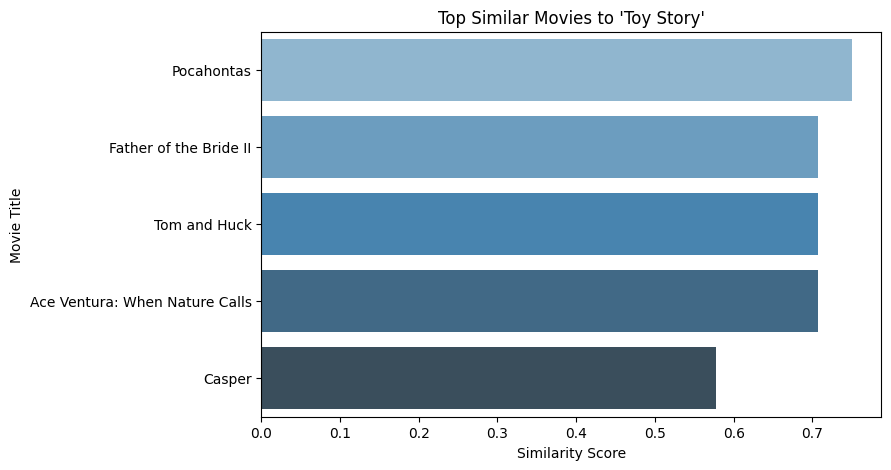


Item-Based CF Recommendations for userId=1:
    movieId         title                             genres  year  \
7         8  Tom and Huck                   Adventure|Family  1995   
0         1     Toy Story  Animation|Adventure|Comedy|Family  1995   
5         6          Heat        Action|Crime|Thriller|Drama  1995   
8         9  Sudden Death                    Action|Thriller  1995   
12       13    Braveheart           Action|Drama|History|War  1995   

    pred_rating  
7      4.022155  
0      3.886678  
5      3.884593  
8      3.845882  
12     3.838909  


In [34]:
# Example: Content-based recommendations
movie_id_example = 1
content_recs = similar_movies_content_based(movie_id_example, top_k=5)

print(f"\nContent-Based Recommendations (similar to movieId={movie_id_example}):")
print(content_recs)

# Visualization: Similar Movies Bar Plot
plt.figure(figsize=(8,5))
sns.barplot(x="similarity", y="title", data=content_recs, palette="Blues_d")
plt.title(f"Top Similar Movies to '{movies.loc[movies.movieId==movie_id_example,'title'].values[0]}'")
plt.xlabel("Similarity Score")
plt.ylabel("Movie Title")
plt.show()

# Example: Collaborative Filtering recommendations
user_example = 1
cf_recs = recommend_itemcf_for_user(user_example, top_k=5)

print(f"\nItem-Based CF Recommendations for userId={user_example}:")
print(cf_recs)


C:\Users\verma\AppData\Local\Temp\ipykernel_15820\3668240863.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="pred_rating", y="title", data=cf_recs, palette="Greens_d")


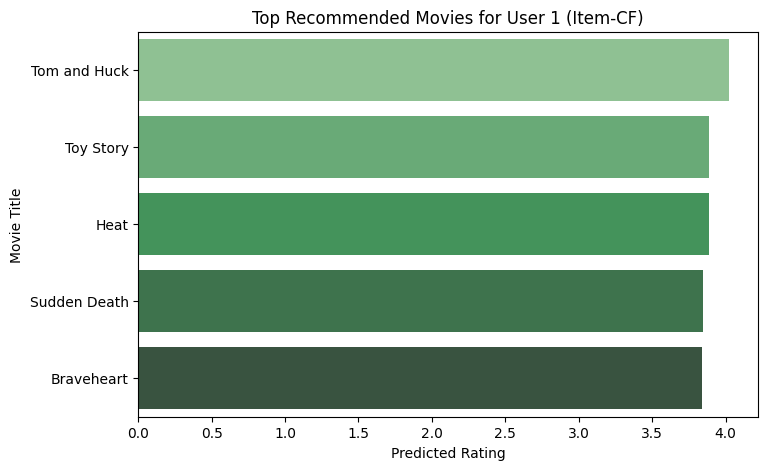

In [37]:
# Visualization: CF Recommendations Bar Plot
plt.figure(figsize=(8,5))
sns.barplot(x="pred_rating", y="title", data=cf_recs, palette="Greens_d")
plt.title(f"Top Recommended Movies for User {user_example} (Item-CF)")
plt.xlabel("Predicted Rating")
plt.ylabel("Movie Title")
plt.show()

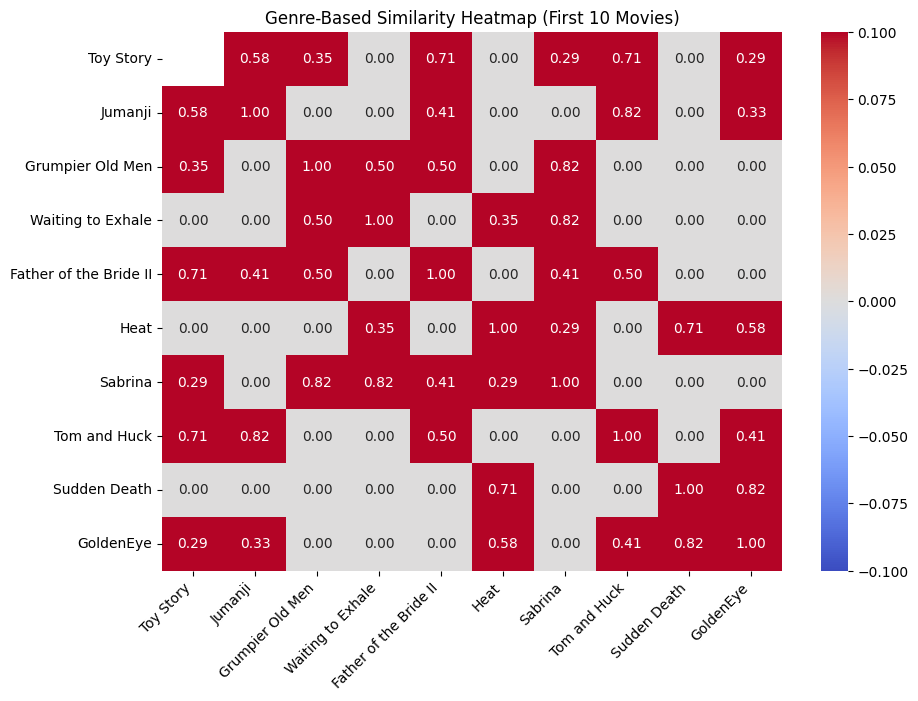

In [36]:
# Visualization: Heatmap of genre similarity between first 10 movies
plt.figure(figsize=(10,7))
sns.heatmap(item_sim_content[:10,:10], xticklabels=movies["title"].head(10), 
            yticklabels=movies["title"].head(10), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Genre-Based Similarity Heatmap (First 10 Movies)")
plt.xticks(rotation=45, ha="right")
plt.show()